In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
from utils import *
import keras
import tflearn
os.environ["CUDA_VISIBLE_DEVICES"]='0'

Using TensorFlow backend.


# Help functions

In [2]:
def get_2_class(imgs, labs):
    label = np.concatenate(labs)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==2)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label
def plot_temp(feature, label):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()  

# Load data

In [3]:
# load cifar 10 data and choose two classes
train_data,test_data = keras.datasets.cifar10.load_data()
feature = train_data[0]
label = train_data[1]
feature, label = get_2_class(feature, label)

# Build model

In [4]:
inputs = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')

# Growth Rate (12, 16, 32, ...)
k = 12

# Depth (40, 100, ...)
L = 40
nb_layers = int((L - 4) / 3)


net = tflearn.conv_2d(inputs, 16, 3, regularizer='L2', weight_decay=0.0001)
net = tflearn.densenet_block(net, nb_layers, k)
net = tflearn.densenet_block(net, nb_layers, k)
net = tflearn.densenet_block(net, nb_layers, k)
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 2, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [5]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training function

In [13]:
batch_size = 256
def optmizer(optimizer_step, epochs):
    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()        
        for ii in range(len(label)//batch_size):
            index = np.random.choice(len(label), batch_size)
            dict_input = {inputs:feature[index], targets:label[index],
                          train_flag: True, 
                          input_shortcut: np.zeros([batch_size, 2])}
            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%50==0:
            saver.save(session,'../model/cifar10_densenet{}.ckpt'.format(i))

# Train and check

In [14]:
saver.restore(session, '../model/cifar10_densenet150.ckpt')

In [15]:
optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-5)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost)
reset_opt_op = tf.variables_initializer([optimizer_sgd_last_layer.get_slot(var, name) 
                for name in optimizer_sgd_last_layer.get_slot_names() for var in last_layer_variables])
session.run(reset_opt_op)

In [ ]:
optmizer(step_sgd_last_layer, 1000)

('Epoche: 1/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.0609661415219', ' | Time for epoch: 22.61s')
('Epoche: 2/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.0664535611868', ' | Time for epoch: 22.66s')
('Epoche: 3/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.0643667504191', ' | Time for epoch: 22.58s')
('Epoche: 4/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.0613653957844', ' | Time for epoch: 22.25s')
('Epoche: 5/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.0719295293093', ' | Time for epoch: 22.24s')
('Epoche: 6/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.0669254437089', ' | Time for epoch: 22.28s')
('Epoche: 7/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.0623386390507', ' | Time for epoch: 22.28s')
('Epoche: 8/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.0662399157882', ' | Time for epoch: 22.31s')
('Epoche: 9/1000', '| Training accuracy: ', 0.96875, '| Cost: 0.0684274956584', ' | Time for epoch: 22.29s')


In [8]:
batch_size_test = 256
# def get_transform_feature():
feature_t = []
label_t = []
image_object = batch_object(feature, batch_size)
label_object = batch_object(label, batch_size)
for ii in range(len(label)//batch_size_test):
    imgs = image_object.next_batch()
    labs = label_object.next_batch()
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs,
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


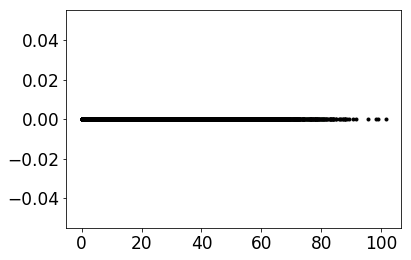

In [9]:
plot_temp(feature_t, label_t)